# Transfer Learning with TensorFlow Part 1: Feature Extraction

Transfer learning is leveraging a working model's existing architecture and learned patterns for our own problem.

There are two main benefits:

1. Can leverage an existing neural network architecture proven to work on problems similar to our own.
2. Can leverage a working neural network architecture which has already learned patterns on similar data to our own, then we can adapt those patterns to our own data.

In [1]:
!nvidia-smi

Fri May 27 17:23:24 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   44C    P8    10W /  70W |      0MiB / 15109MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

## Downloading the data

In [3]:
# Get the data (10% of 10 food classes from Food101)
import zipfile

# Download the data
!wget https://storage.googleapis.com/ztm_tf_course/food_vision/10_food_classes_10_percent.zip

# Unzip the downloaded file
zip_ref = zipfile.ZipFile("10_food_classes_10_percent.zip")
zip_ref.extractall()
zip_ref.close()

--2022-05-27 17:26:28--  https://storage.googleapis.com/ztm_tf_course/food_vision/10_food_classes_10_percent.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 108.177.111.128, 142.250.1.128, 108.177.120.128, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|108.177.111.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 168546183 (161M) [application/zip]
Saving to: ‘10_food_classes_10_percent.zip.1’

10_food_classes_10_ 100%[===================>] 160.74M   301MB/s    in 0.5s    

2022-05-27 17:26:29 (301 MB/s) - ‘10_food_classes_10_percent.zip.1’ saved [168546183/168546183]



In [4]:
# Checking the number of images in each folder
import os

# Walk through 10 percent data directory and list the number of files
for dirpath, dirnames, filenames in os.walk("10_food_classes_10_percent"):
  print(f"There are {len(dirnames)} directories and {len(filenames)} images in '{dirpath}'.")


There are 2 directories and 0 images in '10_food_classes_10_percent'.
There are 10 directories and 0 images in '10_food_classes_10_percent/test'.
There are 0 directories and 250 images in '10_food_classes_10_percent/test/sushi'.
There are 0 directories and 250 images in '10_food_classes_10_percent/test/chicken_wings'.
There are 0 directories and 250 images in '10_food_classes_10_percent/test/hamburger'.
There are 0 directories and 250 images in '10_food_classes_10_percent/test/ice_cream'.
There are 0 directories and 250 images in '10_food_classes_10_percent/test/steak'.
There are 0 directories and 250 images in '10_food_classes_10_percent/test/ramen'.
There are 0 directories and 250 images in '10_food_classes_10_percent/test/chicken_curry'.
There are 0 directories and 250 images in '10_food_classes_10_percent/test/grilled_salmon'.
There are 0 directories and 250 images in '10_food_classes_10_percent/test/fried_rice'.
There are 0 directories and 250 images in '10_food_classes_10_percent

## creating data loaders (preparing the data)

We'll use the `ImageDataGenerator` class to load in our images in batches

In [7]:
# Setup data inputs
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Usually all caps are used for variables that are used in for hyper-parameters
IMG_SHAPE = (224, 224)
BATCH_SIZE = 32

train_dir = "10_food_classes_10_percent/train/"
test_dir = "10_food_classes_10_percent/test/"

train_datagen = ImageDataGenerator(rescale = 1/255.)
test_datagen = ImageDataGenerator(rescale = 1/255.)

print("Training images:")
train_data_10_percent = train_datagen.flow_from_directory(train_dir,
                                                          target_size = IMG_SHAPE,
                                                          batch_size = BATCH_SIZE,
                                                          class_mode = "categorical")
print("Testing images:")
test_data = test_datagen.flow_from_directory(test_dir,
                                            target_size = IMG_SHAPE,
                                            batch_size = BATCH_SIZE,
                                            class_mode = "categorical")

Training images:
Found 750 images belonging to 10 classes.
Testing images:
Found 2500 images belonging to 10 classes.


## Setting up callbacks (things to run whilst our model trains)

Callbacks are extra functionality you can add to your models to be performed during or after training.

Popular callbacks:

* Tracking experiments with TensorBoard callback
* Model checkpoint with the ModelCheckpoint callback
* Stopping a model from training (before it trains too long and overfits) with the EarlyStopping callback

In [9]:
# Create TensorBoard callback (functionized because we need to create a new for each model)

import datetime

def create_tensorboard_callback(dir_name, experiment_name):
  log_dir = dir_name + "/" + experiment_name + "/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
  tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir = log_dir)
  print(f"Saving TensorBoard log files to: {log_dir}")
  return tensorboard_callback

## Creating models using TensorFlow Hub

In [10]:
# Let's compare the following two models

resnet_url = "https://tfhub.dev/google/imagenet/resnet_v2_50/feature_vector/5"

efficientnet_url = "https://tfhub.dev/tensorflow/efficientnet/b0/feature-vector/1"

In [11]:
# Import dependencies

import tensorflow as tf
import tensorflow_hub as hub
from tensorflow.keras import layers

In [14]:
# A function to create a model from a URL

def create_model(model_url, num_classes = 10):
  """
  Takes a TensorFlow HUB URL and creates a keras Sequential model with it.

  Args:
    model_url (str): A TensorFlow Hub feature extraction URL.
    num_classes (int): Number of ouptut neurons in the output layer,
      should be equal to number of target classes, default 10.

  Returns:
    An uncompiled Keras Sequential model with model_url as feature extractor
    layer and Dense output layer with num_classes output neurons.
  """

  # Download the pretrained model and save it as a Keras layer
  feature_extractor_layer = hub.KerasLayer(model_url,
                                           trainable = False, # freeze the already learned patterns
                                           name = "feature_extraction_layer",
                                           input_shape = IMG_SHAPE + (3,))
  
  # Create own model
  model = tf.keras.Sequential([
                               feature_extractor_layer,
                               layers.Dense(num_classes, activation = "softmax", name = "ouput_layer")
  ])

  return model

### Creating and testing ResNet TensorFlow Hub Feature Extraction model

In [15]:
# Create Resnet model

resnet_model = create_model(resnet_url,
                            num_classes = train_data_10_percent.num_classes)

In [17]:
# Compile the resnet model

resnet_model.compile(loss = "categorical_crossentropy",
                     optimizer = tf.keras.optimizers.Adam(),
                     metrics = ["accuracy"])

In [16]:
resnet_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 feature_extraction_layer (K  (None, 2048)             23564800  
 erasLayer)                                                      
                                                                 
 ouput_layer (Dense)         (None, 10)                20490     
                                                                 
Total params: 23,585,290
Trainable params: 20,490
Non-trainable params: 23,564,800
_________________________________________________________________


In [19]:
# Fitting the ResNet model to the data (10% of the 10 classes)

resnet_history = resnet_model.fit(train_data_10_percent,
                                  epochs = 5,
                                  steps_per_epoch = len(train_data_10_percent),
                                  validation_data = test_data,
                                  validation_steps = len(test_data),
                                  callbacks = [create_tensorboard_callback(dir_name = "tensorflow_hub",
                                                                           experiment_name = "resnetV250")])

Saving TensorBoard log files to: tensorflow_hub/resnetV250/20220527-185325
Epoch 1/5
24/24 [==============================] - 31s 744ms/step - loss: 1.9894 - accuracy: 0.3253 - val_loss: 1.2396 - val_accuracy: 0.5912
Epoch 2/5
24/24 [==============================] - 16s 672ms/step - loss: 0.9313 - accuracy: 0.7280 - val_loss: 0.8478 - val_accuracy: 0.7300
Epoch 3/5
24/24 [==============================] - 16s 669ms/step - loss: 0.6291 - accuracy: 0.8293 - val_loss: 0.7616 - val_accuracy: 0.7524
Epoch 4/5
24/24 [==============================] - 16s 673ms/step - loss: 0.4840 - accuracy: 0.8787 - val_loss: 0.7030 - val_accuracy: 0.7744
Epoch 5/5
24/24 [==============================] - 16s 675ms/step - loss: 0.3803 - accuracy: 0.9147 - val_loss: 0.6769 - val_accuracy: 0.7808


In [22]:
import matplotlib.pyplot as plt
def plot_loss_curves(history):
  """
  Returns seperate loss curves for training and validaion metrics.

  Args:
    history: TensorFlow history object

  Returns:
    Plots of training/validation loss and accuracy metrics
  """
  
  loss = history.history["loss"]
  val_loss = history.history["val_loss"]

  accuracy = history.history["accuracy"]
  val_accuracy = history.history["val_accuracy"]

  epochs = range(len(history.history["loss"])) # how many epochs we run for

  # Plot loss
  plt.plot(epochs, loss, label = "training_loss")
  plt.plot(epochs, val_loss, label = "val_loss")
  plt.title("loss")
  plt.xlabel("epochs")
  plt.legend()

  # Plot accuracy
  plt.figure()
  plt.plot(epochs, accuracy, label = "training_accuracy")
  plt.plot(epochs, val_accuracy, label = "val_accuracy")
  plt.title("accuracy")
  plt.xlabel("epochs")
  plt.legend()

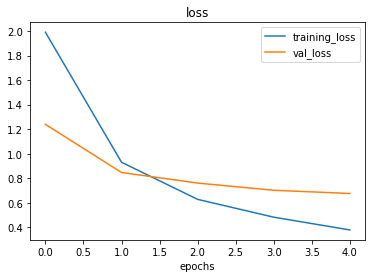

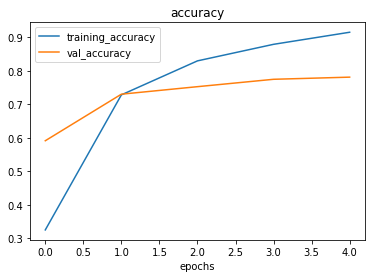

In [21]:
plot_loss_curves(resnet_history)

### Creating and testing EfficientNetB0 TensorFlow Hub Feature Extraction model

In [26]:
# Create EfficientNetB0 feature extractor model
efficientnet_model = create_model(model_url = efficientnet_url,
                                  num_classes =  train_data_10_percent.num_classes)

# Compile EfficientNet model
efficientnet_model.compile(loss = "categorical_crossentropy",
                           optimizer = tf.keras.optimizers.Adam(),
                           metrics = ["accuracy"])

# Fit the model
efficientnet_history = efficientnet_model.fit(train_data_10_percent,
                                              epochs = 5,
                                              steps_per_epoch = len(train_data_10_percent),
                                              validation_data = test_data,
                                              validation_steps = len(test_data),
                                              callbacks = [create_tensorboard_callback(dir_name = "tensorflow_hub",
                                                                                       experiment_name = "efficientnetb0")])

Saving TensorBoard log files to: tensorflow_hub/efficientnetb0/20220527-193548
Epoch 1/5
24/24 [==============================] - 25s 721ms/step - loss: 1.8102 - accuracy: 0.4600 - val_loss: 1.2533 - val_accuracy: 0.7188
Epoch 2/5
24/24 [==============================] - 15s 647ms/step - loss: 1.0389 - accuracy: 0.7787 - val_loss: 0.8507 - val_accuracy: 0.8240
Epoch 3/5
24/24 [==============================] - 15s 638ms/step - loss: 0.7461 - accuracy: 0.8400 - val_loss: 0.6856 - val_accuracy: 0.8444
Epoch 4/5
24/24 [==============================] - 24s 1s/step - loss: 0.6015 - accuracy: 0.8760 - val_loss: 0.6015 - val_accuracy: 0.8600
Epoch 5/5
24/24 [==============================] - 15s 646ms/step - loss: 0.5088 - accuracy: 0.8893 - val_loss: 0.5510 - val_accuracy: 0.8628


In [28]:
efficientnet_model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 feature_extraction_layer (K  (None, 1280)             4049564   
 erasLayer)                                                      
                                                                 
 ouput_layer (Dense)         (None, 10)                12810     
                                                                 
Total params: 4,062,374
Trainable params: 12,810
Non-trainable params: 4,049,564
_________________________________________________________________


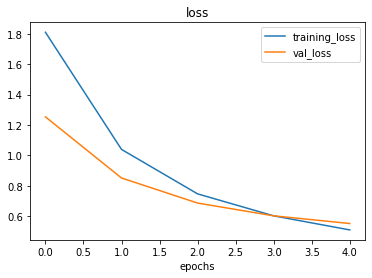

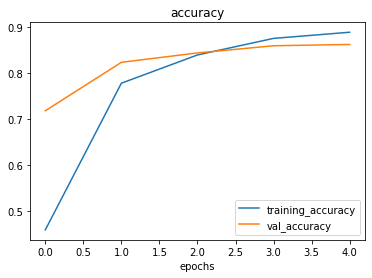

In [29]:
plot_loss_curves(efficientnet_history)

## Comparing the model results using TensorBoard





### Different types of transfer learning

* **"As is" transfer learning** - using an existing model with no changes what so ever (e.g using ImageNet model on 1000 ImageNet classes, none of your own)

* **"Feature extraction" transfer learning** - use the prelearned patterns of an existing model (e.g. EfficientNetB0 trained on ImageNet) and adjust the output layer for your own problem (e.g. 1000 classes -> 10 classes of food)

* **"Fine-tuning" transfer learning** - use the prelearned patterns of an existing model and "fine-tune" many or all of the underlying layers (including new output layers)

In [31]:
# Upload TensorBoard dev records
!tensorboard dev upload --logdir ./tensorflow_hub/ \
  --name "EfficientNetB0 vs. ResNet50V2" \
  --description "Comparing two different TF Hub feature extraction model architectures using 10% of the training data" \
  --one_shot


***** TensorBoard Uploader *****

This will upload your TensorBoard logs to https://tensorboard.dev/ from
the following directory:

./tensorflow_hub/

This TensorBoard will be visible to everyone. Do not upload sensitive
data.

Your use of this service is subject to Google's Terms of Service
<https://policies.google.com/terms> and Privacy Policy
<https://policies.google.com/privacy>, and TensorBoard.dev's Terms of Service
<https://tensorboard.dev/policy/terms/>.

This notice will not be shown again while you are logged into the uploader.
To log out, run `tensorboard dev auth revoke`.

Continue? (yes/NO) yes

Please visit this URL to authorize this application: https://accounts.google.com/o/oauth2/auth?response_type=code&client_id=373649185512-8v619h5kft38l4456nm2dj4ubeqsrvh6.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=openid+https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fuserinfo.email&state=VUxKInvhaa1ENzgHnH4oEECn8r5qOK&prompt=consent&access_type=off

In [32]:
# Check out the TensorBoard experiments we have at the moment
!tensorboard dev list

https://tensorboard.dev/experiment/R7NraX9KRlmOJ0G7aXl4Kw/
	Name                 EfficientNetB0 vs. ResNet50V2
	Description          Comparing two different TF Hub feature extraction model architectures using 10% of the training data
	Id                   R7NraX9KRlmOJ0G7aXl4Kw
	Created              2022-05-27 20:04:26 (5 minutes ago)
	Updated              2022-05-27 20:04:28 (5 minutes ago)
	Runs                 4
	Tags                 5
	Scalars              60
	Tensor bytes         0
	Binary object bytes  5795825
Total: 1 experiment(s)


In [ ]:
# Delete an experiment
#!tensorboard dev delete --experiment_id